In [1]:
from train import learn_model
from agent_distribution import AgentDistribution
from utils import compute_continuity_noise, fixed_point_interpolation_true_distribution, convert_to_unit_vector
from optimal_beta import optimal_beta_expected_policy_loss 
from reparametrized_gradient import plot_total_derivative

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
def create_challenging_agent_dist(n, n_types, d):
    gaming_type_etas = np.random.uniform(3., 5., int(n_types * d/2)).reshape(int(n_types/2), d, 1)
    gaming_type_gamma_one = np.random.uniform(0.01, 0.02, int(n_types/2) ).reshape(int(n_types/2), 1, 1)
    gaming_type_gamma_two = np.random.uniform(10., 20., int(n_types/2)).reshape(int(n_types/2), 1, 1)
    gaming_type_gammas = np.hstack((gaming_type_gamma_one, gaming_type_gamma_two))
    
    natural_type_etas = np.random.uniform(5., 7., int(n_types *d/2)).reshape(int(n_types/2), d, 1)
    natural_type_gammas = np.random.uniform(10., 20., int(n_types * d/2)).reshape(int(n_types/2), d, 1)
    
    etas = np.vstack((gaming_type_etas, natural_type_etas))
    gammas = np.vstack((gaming_type_gammas, natural_type_gammas))
    dic = {"etas": etas, "gammas": gammas}
    agent_dist = AgentDistribution(n=n, d=d, n_types=n_types, types=dic, prop=None)
    return agent_dist

In [3]:
n = 1000000
n_types = 10
d = 2
np.random.seed(0)
agent_dist = create_challenging_agent_dist(n, n_types, d)
sigma = compute_continuity_noise(agent_dist)
q = 0.7
f = fixed_point_interpolation_true_distribution(agent_dist, sigma, q)

100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]


In [4]:
min_loss, opt_beta, opt_s_beta, thetas, losses = optimal_beta_expected_policy_loss(agent_dist, sigma, f, plot=False)
opt_theta = np.arctan2(opt_beta[1], opt_beta[0])
print("Opt Theta: {}".format(opt_theta.item()))
print("Min Loss: {}".format(min_loss))

Opt Theta: 1.1540544441758422
Min Loss: -1.6161331288660925


0.6877690225804196
0.345542819960959


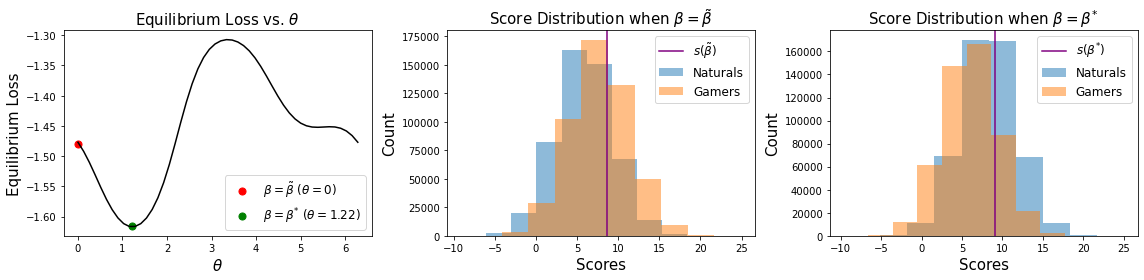

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
thetas = np.linspace(0, 2*np.pi, len(losses))
ax[0].plot(thetas, losses, c="black")
ax[0].scatter([0.], [-1.48], label=r"$\beta = \tilde{\beta}$" + " " + r"$(\theta= 0)$", c="r", s=50, alpha=1)
ax[0].scatter([1.218], [-1.616], label=r"$\beta = \beta^{*}$" + " " + r"$(\theta= 1.22)$", c="g", s=50, alpha=1)
ax[0].set_xlabel(r"$\theta$", fontsize=15)
ax[0].set_ylabel("Equilibrium Loss", fontsize=15)
ax[0].set_title("Equilibrium Loss" + " vs. " + r"$\theta$", fontsize=15)
ax[0].legend(fontsize=12)

all_br = agent_dist.best_response_noisy_score_distribution(opt_beta, opt_s_beta, sigma)
natural_types_idx = np.where(agent_dist.n_agent_types >= int(n_types/2))
gaming_types_idx = np.where(agent_dist.n_agent_types < int(n_types/2))

ax[2].hist(all_br[natural_types_idx], label="Naturals", alpha=0.5)
ax[2].hist(all_br[gaming_types_idx], label="Gamers", alpha=0.5)
ax[2].axvline(x=opt_s_beta, c="purple", label=r"$s(\beta^{*})$")
ax[2].set_title("Score Distribution when " + r"$\beta = \beta^{*}$", fontsize=15)
ax[2].set_xlabel("Scores", fontsize=15)
ax[2].set_ylabel("Count", fontsize=15)
ax[2].legend(fontsize=12)

nat_above = all_br[natural_types_idx] > opt_s_beta
gam_above = all_br[gaming_types_idx] > opt_s_beta

print(nat_above.sum()/ (nat_above.sum() + gam_above.sum()))

default_theta = 0.
default_beta = convert_to_unit_vector(np.array([default_theta]).reshape(1,1))
default_s_beta = f(default_theta)

all_br = agent_dist.best_response_noisy_score_distribution(default_beta, default_s_beta, sigma)
natural_types_idx = np.where(agent_dist.n_agent_types >= int(n_types/2))
gaming_types_idx = np.where(agent_dist.n_agent_types < int(n_types/2))

nat_above = all_br[natural_types_idx] > default_s_beta
gam_above = all_br[gaming_types_idx] > default_s_beta

print(nat_above.sum()/ (nat_above.sum() + gam_above.sum()))

ax[1].hist(all_br[natural_types_idx], label="Naturals", alpha=0.5)
ax[1].hist(all_br[gaming_types_idx], label="Gamers", alpha=0.5)
ax[1].axvline(x=default_s_beta, c="purple", label=r"$s(\tilde{\beta})$")
ax[1].set_title("Score Distribution when " + r"$\beta = \tilde{\beta}$", fontsize=15)
ax[1].set_xlabel("Scores", fontsize=15)
ax[1].set_ylabel("Count", fontsize=15)
ax[1].legend(fontsize=12)

plt.tight_layout()

plt.savefig("figs/paper-figure-3.pdf")